In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import gvar as gv
import h5py as h5
import lsqfit
import NN_lib as nn

# set parameters

In [2]:
# parameters
params = dict()
params['data_select'] = ['new_nucleon','new_nn_I0_nsq_0_nonlocal']
params['ansatz'] = 'simultaneous'
params['nstates'] = 3
params['tmin'] = [2,10]
params['tmax'] = [30,30]
# set priors
prior = dict()
# single nucleon
# energy
prior['nucleon_E0'] = gv.gvar(1.2,0.12)
prior['nucleon_E1'] = gv.gvar(0.17,0.69)
prior['nucleon_E2'] = gv.gvar(0.17,0.69)
prior['nucleon_E3'] = gv.gvar(0.17,0.69)
# old overlap factor
prior['old_nucleon_A0'] = gv.gvar(2.4E-9,1.2E-9)
prior['old_nucleon_A1'] = gv.gvar(0.0,2.4E-9)
prior['old_nucleon_A2'] = gv.gvar(0.0,2.4E-9)
prior['old_nucleon_A3'] = gv.gvar(0.0,2.4E-9)
# new overlap factor
prior['new_nucleon_A0'] = gv.gvar(3.3E-6,1.6E-6)
prior['new_nucleon_A1'] = gv.gvar(0.0,3.3E-6)
prior['new_nucleon_A2'] = gv.gvar(0.0,3.3E-6)
prior['new_nucleon_A3'] = gv.gvar(0.0,3.3E-6)
# deuteron zero momentum
# energy
#log splitting: [-2.87436727 -2.89709403 -2.91883231 -2.93966453]
#err splitting: [-0.68184836 -0.39453147 -0.27708849 -0.21286751]
prior['nn_I0_nsq_0_E0'] = gv.gvar(2.4,0.24)
prior['nn_I0_nsq_0_E1'] = gv.gvar(-2.9,0.7)
prior['nn_I0_nsq_0_E2'] = gv.gvar(-2.9,0.4)
prior['nn_I0_nsq_0_E3'] = gv.gvar(-2.9,0.3)
# new nonlocal overlap factor
prior['new_nn_I0_nsq_0_nonlocal_A0'] = gv.gvar(2.2E-9,1.1E-9)
prior['new_nn_I0_nsq_0_nonlocal_A1'] = gv.gvar(0.0,2.2E-9)
prior['new_nn_I0_nsq_0_nonlocal_A2'] = gv.gvar(0.0,2.2E-9)
prior['new_nn_I0_nsq_0_nonlocal_A3'] = gv.gvar(0.0,2.2E-9)
# old nonlocal overlap factor
prior['old_nn_I0_nsq_0_nonlocal_A0'] = gv.gvar(2.2E-9,1.1E-9)
prior['old_nn_I0_nsq_0_nonlocal_A1'] = gv.gvar(0.0,2.2E-9)
prior['old_nn_I0_nsq_0_nonlocal_A2'] = gv.gvar(0.0,2.2E-9)
prior['old_nn_I0_nsq_0_nonlocal_A3'] = gv.gvar(0.0,2.2E-9)

# read 800MeV clover data from hdf5

In [3]:
# old data
old_h5 = h5.File('./data/nn_old_cl3_b6p1_m0p02450.h5')
old_data = nn.read_data(old_h5)
old_h5.close()
# new data
new_h5 = h5.File('./data/nn_new_cl3_b6p1_m0p02450.h5')
new_data = nn.read_data(new_h5)
new_h5.close()

# use only intersecting configurations

In [4]:
new_idx = dict()
old_idx = dict()
for s in ['a','b']:
    n_idx = dict((cfg,idx) for idx,cfg in enumerate(new_data[s]['cfg']))
    o_idx = dict((cfg,idx) for idx,cfg in enumerate(old_data[s]['cfg']))
    intersect = np.sort(list(set(new_data[s]['cfg']).intersection(set(old_data[s]['cfg']))))
    new_idx[s] = [n_idx[idx] for idx in intersect]
    old_idx[s] = [o_idx[idx] for idx in intersect]
idx = {'old': old_idx, 'new': new_idx}
dat = {'old': old_data, 'new': new_data}
data = dict()
for t in ['old','new']:
    data['%s_nucleon' %t] = np.concatenate((dat[t]['a']['nucleon'][idx[t]['a']],dat[t]['b']['nucleon'][idx[t]['b']]),axis=0)
    for i in ['nn_I0','nn_I1']:
        for q in ['nsq_0','nsq_1','nsq_2','nsq_3']:
            for sidx,src in enumerate(['local','nonlocal']):
                data['%s_%s_%s_%s' %(t,i,q,src)] = np.concatenate((dat[t]['a'][i][q][idx[t]['a']],dat[t]['b'][i][q][idx[t]['b']]),axis=0).real[:,:,sidx]
gvdata = gv.dataset.avg_data(data)
gvdata.keys()

odict_keys(['old_nucleon', 'old_nn_I0_nsq_0_local', 'old_nn_I0_nsq_0_nonlocal', 'old_nn_I0_nsq_1_local', 'old_nn_I0_nsq_1_nonlocal', 'old_nn_I0_nsq_2_local', 'old_nn_I0_nsq_2_nonlocal', 'old_nn_I0_nsq_3_local', 'old_nn_I0_nsq_3_nonlocal', 'old_nn_I1_nsq_0_local', 'old_nn_I1_nsq_0_nonlocal', 'old_nn_I1_nsq_1_local', 'old_nn_I1_nsq_1_nonlocal', 'old_nn_I1_nsq_2_local', 'old_nn_I1_nsq_2_nonlocal', 'old_nn_I1_nsq_3_local', 'old_nn_I1_nsq_3_nonlocal', 'new_nucleon', 'new_nn_I0_nsq_0_local', 'new_nn_I0_nsq_0_nonlocal', 'new_nn_I0_nsq_1_local', 'new_nn_I0_nsq_1_nonlocal', 'new_nn_I0_nsq_2_local', 'new_nn_I0_nsq_2_nonlocal', 'new_nn_I0_nsq_3_local', 'new_nn_I0_nsq_3_nonlocal', 'new_nn_I1_nsq_0_local', 'new_nn_I1_nsq_0_nonlocal', 'new_nn_I1_nsq_1_local', 'new_nn_I1_nsq_1_nonlocal', 'new_nn_I1_nsq_2_local', 'new_nn_I1_nsq_2_nonlocal', 'new_nn_I1_nsq_3_local', 'new_nn_I1_nsq_3_nonlocal'])

# plot nucleon

In [5]:
switch = 'old_nn_I0_nsq_0_nonlocal'
#nn.plot_meff(gvdata[switch])
#nn.plot_scor(gvdata[switch])

# calculate NN excited state

In [6]:
n = np.sqrt([0,1,2,3,4,5])
L = 24
mN = 1.2
es = np.sqrt(mN**2 + (2.*np.pi*n/L)**2)
D = 2*(es - mN)
print('MeV splitting:', 197/0.1453*D[1:])
Dn = (np.roll(D,-1)-D)[:-1]
print('log splitting:', np.log(Dn)[:-1])
print('err splitting:', (np.log(D[1:])-np.log(np.roll(D[1:],-1)))[:-1])

MeV splitting: [  76.53829254  151.35673453  224.56630286  296.26652923  366.54708748]
log splitting: [-2.87436727 -2.89709403 -2.91883231 -2.93966453]
err splitting: [-0.68184836 -0.39453147 -0.27708849 -0.21286751]


# fit correlators

In [7]:
# instantiate fit class
Fit = nn.Fit(params)
# select prior
p = Fit.priors(prior)
# vary fit over tmin and tmax
result = []
for tmin in range(params['tmin'][0],params['tmin'][1]+1):
    for tmax in range(params['tmax'][0],params['tmax'][1]+1):
        x = np.arange(tmin,tmax+1)
        y = {key: gvdata[key][x] for key in params['data_select']}
        fit = lsqfit.nonlinear_fit(data=(x,y),prior=p,fcn=Fit.fit_function)
        result.append((tmin,tmax,fit))
result = np.array(result)

# plot stability of results

<IPython.core.display.Javascript object>


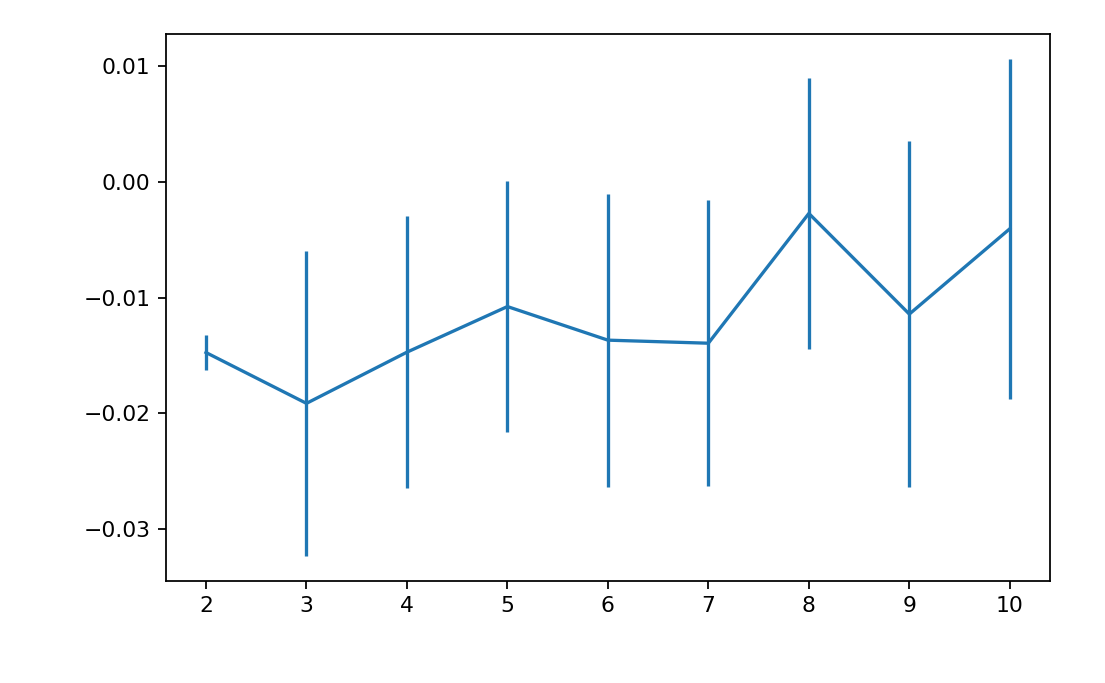

[(2, -0.0147(15)), (3, -0.019(13)), (4, -0.015(12)), (5, -0.011(11)), (6, -0.014(13)), (7, -0.014(12)), (8, -0.003(12)), (9, -0.011(15)), (10, -0.004(15))]


<IPython.core.display.Javascript object>


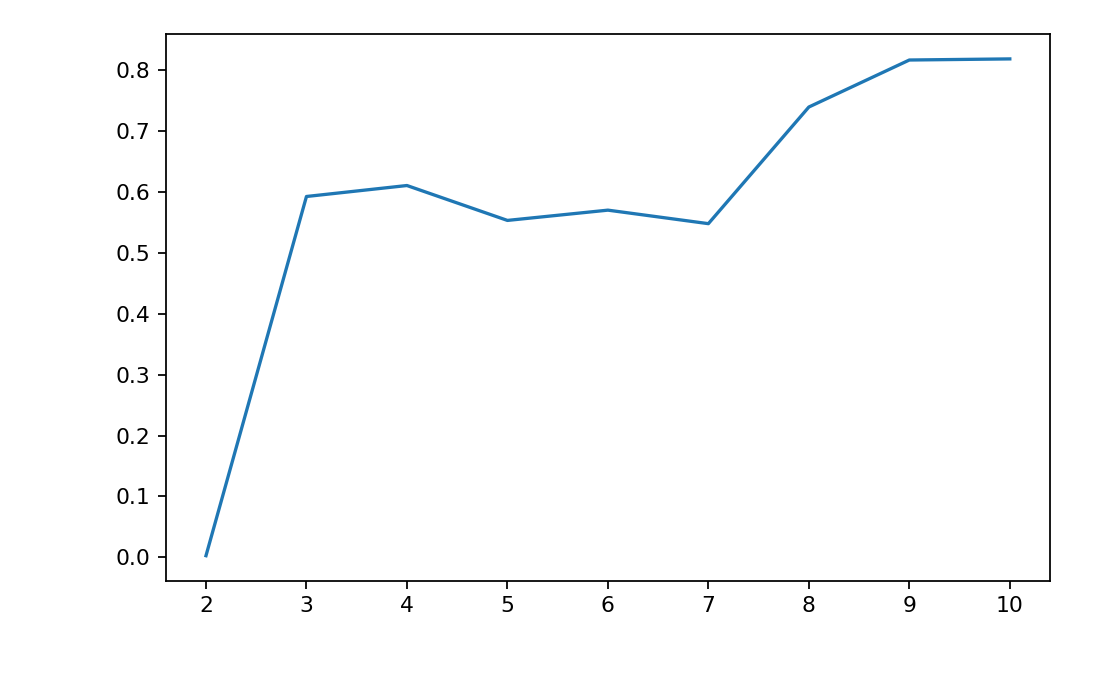

In [8]:
fig = plt.figure('stability plot',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
# get x axis
if params['tmin'][1]-params['tmin'][0] > 0:
    x = result[:,0]
else:
    x = result[:,1]
y = [r.p['nn_I0_nsq_0_E0']-2*r.p['nucleon_E0'] for r in result[:,2]]
ax.errorbar(x=x,y=[i.mean for i in y],yerr=[i.sdev for i in y])
print(list(zip(x,y)))
plt.draw()
fig = plt.figure('Q-value',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
ax.errorbar(x=x,y=[r.Q for r in result[:,2]])
plt.draw()